In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import seaborn as sns
import random
from PIL import Image
import cv2
from matplotlib import rcParams
import re

In [2]:
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, matthews_corrcoef
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [3]:
main_folder = '../input/archie-comics-multi-class/Multi-class'

In [4]:
samples_per_class = []
classes = []
file_names = []

In [5]:
directory=os.listdir('../input/archie-comics-multi-class/Multi-class/')
for each in directory:
    currentFolder = '../input/archie-comics-multi-class/Multi-class/' + each
    count = sum(len(files) for _, _, files in os.walk(currentFolder))
    samples_per_class.append(count)
    classes.append(each)
    
    for i, file in enumerate(os.listdir(currentFolder)):
        fullpath = currentFolder+ "/" + file
        file_names.append(fullpath)

In [6]:
min(samples_per_class)

33

In [7]:
small_ds = []

In [8]:
for each_class in classes:
    trial_list = []
    for name in file_names:
        if re.search(f'{each_class}', name):
            trial_list.append(name)
    small_ds.append(random.sample(trial_list, min(samples_per_class)))

In [9]:
print(len(small_ds))
print(len(small_ds[0]))
print(len(small_ds)*len(small_ds[0]))

23
33
759


In [10]:
small_ds=list(np.concatenate(small_ds).flat)
# For flattening small_ds into a 1-D list

In [11]:
print(len(small_ds))

759


In [12]:
classes

['Kleats',
 'Midge',
 'Dilton',
 'Pop Tate',
 'Reggie',
 'Jughead',
 'Grundy',
 'Ethel',
 'Weatherbee',
 'Harry Clayton',
 'Smithers',
 'Svenson',
 'Moose',
 'Chuck',
 'Nancy',
 'Veronica',
 'Flutesnoot',
 'Fred Andrews',
 'Archie',
 'Betty',
 'Beazley',
 'Hiram Lodge',
 'Others']

In [13]:
small_ds[720:730]

['../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_147.png',
 '../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_121.png',
 '../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_080.png',
 '../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_030.png',
 '../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_069.png',
 '../input/archie-comics-multi-class/Multi-class/Hiram Lodge/Hiram Lodge_040.png',
 '../input/archie-comics-multi-class/Multi-class/Others/Others_126.png',
 '../input/archie-comics-multi-class/Multi-class/Others/Others_153.png',
 '../input/archie-comics-multi-class/Multi-class/Others/Others_395.png',
 '../input/archie-comics-multi-class/Multi-class/Others/Others_356.png']

In [14]:
files_df = pd.DataFrame(index=range(0, len(small_ds)),columns = ['Class'])

In [15]:
start = 0
end = min(samples_per_class)
for each_class in classes:
    files_df.iloc[start:end] = each_class
    start = end
    end = end + min(samples_per_class)

In [16]:
files_df.loc[30:35]

,Class
30,Kleats
31,Kleats
32,Kleats
33,Midge
34,Midge
35,Midge


In [17]:
files_df.loc[65:70]

,Class
65,Midge
66,Dilton
67,Dilton
68,Dilton
69,Dilton
70,Dilton


In [18]:
files_df['Class']=files_df['Class'].astype('str')

In [19]:
files_df['Files'] = small_ds

In [20]:
files_df.tail()

,Class,Files
754,Others,../input/archie-comics-multi-class/Multi-class...
755,Others,../input/archie-comics-multi-class/Multi-class...
756,Others,../input/archie-comics-multi-class/Multi-class...
757,Others,../input/archie-comics-multi-class/Multi-class...
758,Others,../input/archie-comics-multi-class/Multi-class...


In [21]:
files_df = files_df.sample(frac=1, random_state=1).reset_index()
# For randomly shuffling the rows of the dataframe,
# else the training set gets the the top classes, the validation the bottom classes of the df
# random_state is for reproducability, i.e., same distribution each time the code is run

In [22]:
files_df.tail(10)

,index,Class,Files
749,508,Veronica,../input/archie-comics-multi-class/Multi-class...
750,749,Others,../input/archie-comics-multi-class/Multi-class...
751,583,Fred Andrews,../input/archie-comics-multi-class/Multi-class...
752,129,Pop Tate,../input/archie-comics-multi-class/Multi-class...
753,144,Reggie,../input/archie-comics-multi-class/Multi-class...
754,645,Betty,../input/archie-comics-multi-class/Multi-class...
755,715,Hiram Lodge,../input/archie-comics-multi-class/Multi-class...
756,72,Dilton,../input/archie-comics-multi-class/Multi-class...
757,235,Ethel,../input/archie-comics-multi-class/Multi-class...
758,37,Midge,../input/archie-comics-multi-class/Multi-class...


In [23]:
datagen=ImageDataGenerator(validation_split=0.2)

In [24]:
batch_size = 8

In [25]:
train_generator=datagen.flow_from_dataframe(
dataframe=files_df,
directory=None,
x_col='Files',
y_col='Class',
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
# rotation_range=30,
# width_shift_range=0.2,
# height_shift_range=0.2,
# brightness_range=(0.5,1.5),
# shear_range=0.2,
# zoom_range=0.2,
# channel_shift_range=30.0,
# fill_mode='nearest',
# horizontal_flip=True,
# vertical_flip=False,
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=files_df,
directory=None,
x_col='Files',
y_col='Class',
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 608 validated image filenames belonging to 23 classes.
Found 151 validated image filenames belonging to 23 classes.


In [26]:
stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

In [27]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(256, 256, 3), classes=len(classes), include_top = False)


# Based on https://pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),#from_logits=True),
        metrics=["accuracy"]
    )
 
loss_0, acc_0 = model.evaluate(valid_generator)
print(f"loss {loss_0}, acc {acc_0}")
    

history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=50,
        callbacks=[stopping, checkpoint]
)

model.load_weights("best_model")

loss, acc = model.evaluate(valid_generator)
print(f"final loss {loss}, final acc {acc}")

2022-07-01 19:54:53.329860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 19:54:53.455648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 19:54:53.456879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 19:54:53.459751: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


2022-07-01 19:54:58.657030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-01 19:55:01.127569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


19/19 [==============================] - 11s 118ms/step - loss: 4.0418 - accuracy: 0.0464
loss 4.041787147521973, acc 0.046357616782188416
Epoch 1/50
76/76 [==============================] - 10s 99ms/step - loss: 3.8355 - accuracy: 0.0576 - val_loss: 3.1332 - val_accuracy: 0.0596
Epoch 2/50
76/76 [==============================] - 4s 48ms/step - loss: 3.0912 - accuracy: 0.1069 - val_loss: 3.0558 - val_accuracy: 0.0728
Epoch 3/50
76/76 [==============================] - 4s 55ms/step - loss: 2.9210 - accuracy: 0.1480 - val_loss: 2.9986 - val_accuracy: 0.1325
Epoch 4/50
76/76 [==============================] - 4s 51ms/step - loss: 2.7106 - accuracy: 0.1891 - val_loss: 2.9565 - val_accuracy: 0.1523
Epoch 5/50
76/76 [==============================] - 4s 47ms/step - loss: 2.5410 - accuracy: 0.2451 - val_loss: 2.8553 - val_accuracy: 0.1589
Epoch 6/50
76/76 [==============================] - 4s 48ms/step - loss: 2.3858 - accuracy: 0.3224 - val_loss: 2.8336 - val_accuracy: 0.1722
Epoch 7/50
76/

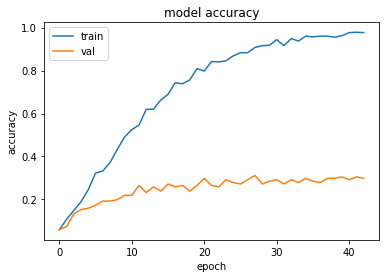

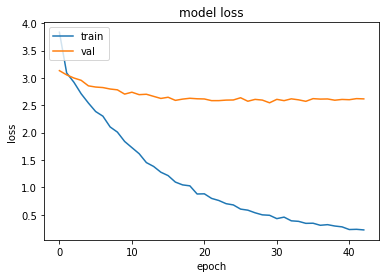

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
index_classes_dict = {k: v for v, k in enumerate(classes)}

In [30]:
index_classes_list = list(index_classes_dict.values())

In [31]:
inv_index_classes_dict = {v: k for k, v in index_classes_dict.items()}

In [32]:
inv_index_classes_list = list(inv_index_classes_dict.values())

In [33]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
i = 0
# iterate over the dataset
for image_batch, label_batch in valid_generator:
    # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
    i+=1
    if i == len(valid_generator): # A generator runs infinitely, 
        # so here I am running the valid gen once so all samples are seen
        # The gen length is valid split * total samples / batch size
        # 0.2*759/8 = 19
        break


# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [34]:
names_correct_labels = np.vectorize(inv_index_classes_dict.get)(correct_labels)
names_predicted_labels = np.vectorize(inv_index_classes_dict.get)(predicted_labels)

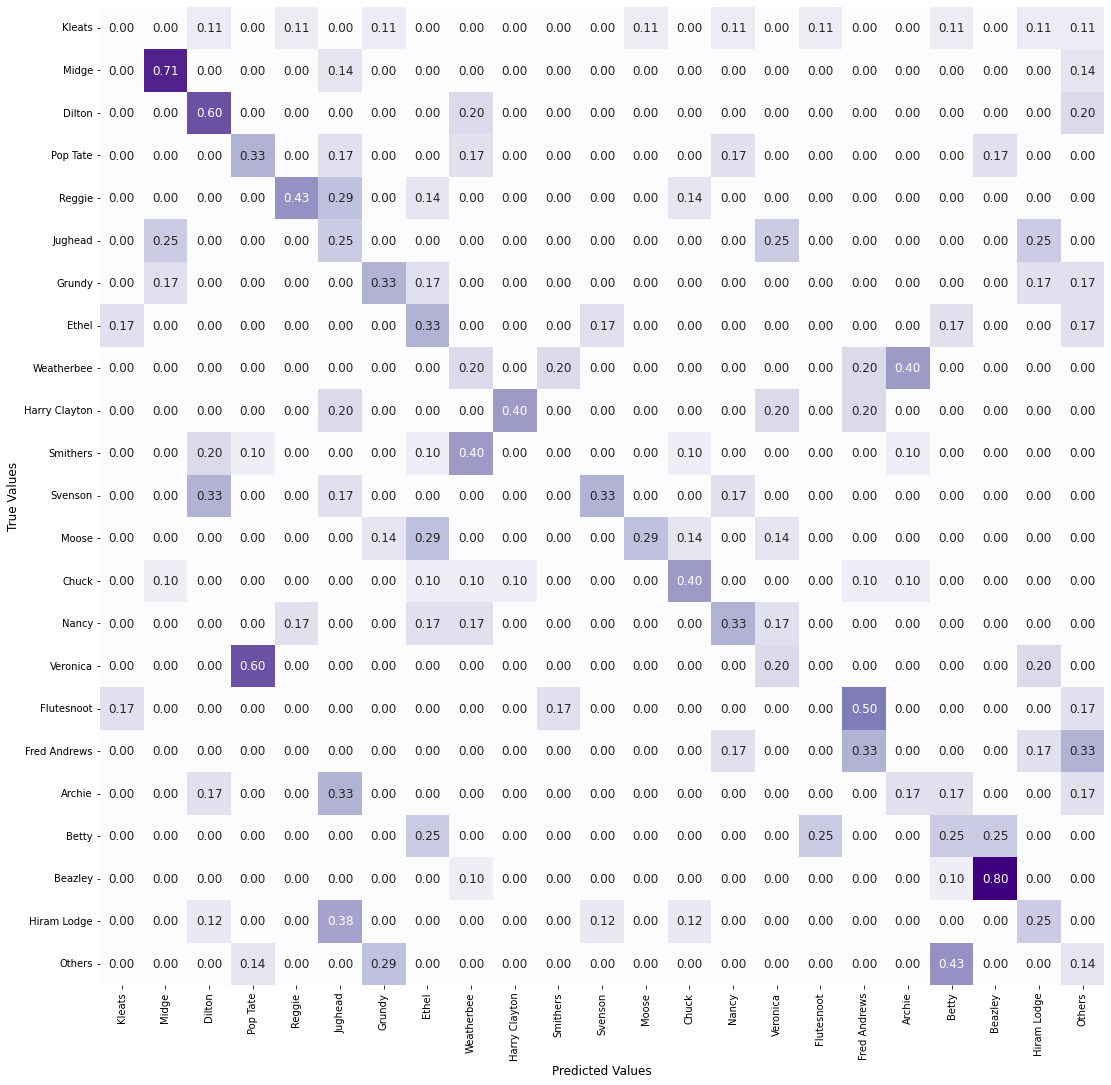

In [35]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list, normalize='true')
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='.2f', 
            xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

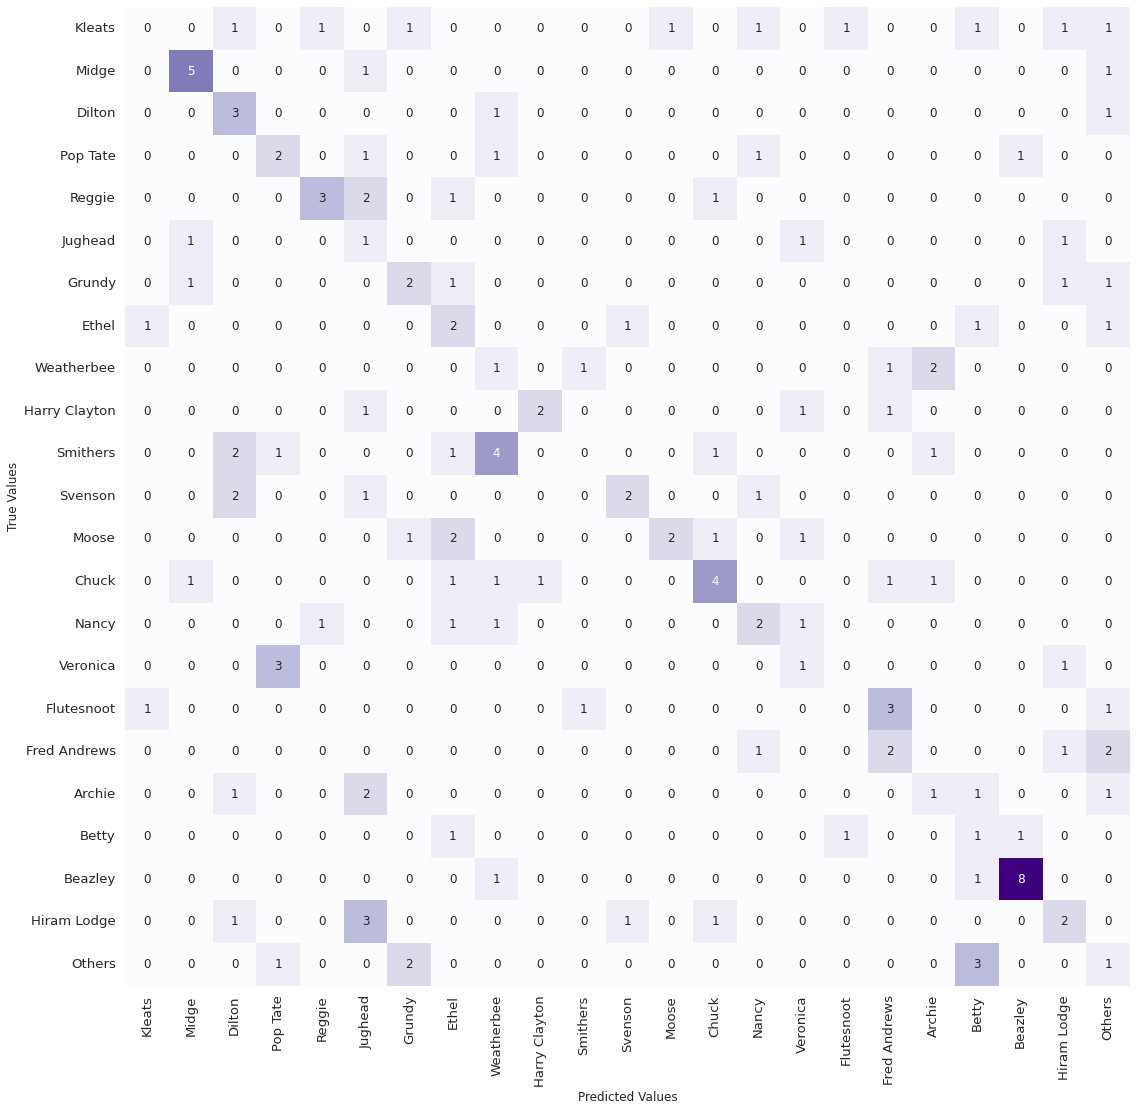

In [36]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list)
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='d',
           xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

In [37]:
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# from https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
TPR[18]

0.16666666666666666

In [38]:
F1 = TP/(TP+(FP+FN)/2)

In [39]:
df_from_arr_2 = pd.DataFrame(data=[TP, FP, TN, FN, F1]).T
df_from_arr_2.rename(columns={0: "True positives", 1: "False positives",
                           2: "True negatives", 3: "False negatives", 4: "F1 score"}, inplace = True)
df_from_arr_2.index = classes
df_from_arr_2["F1 score"] = df_from_arr_2["F1 score"].round(2)

#Total sum per column: 
df_from_arr_2.loc['Total']= df_from_arr_2.sum(axis=0)
df_from_arr_2.iloc[-1,-1]= np.nan

print(df_from_arr_2)

               True positives  False positives  True negatives  \
Kleats                    0.0              2.0           140.0   
Midge                     5.0              3.0           141.0   
Dilton                    3.0              7.0           139.0   
Pop Tate                  2.0              5.0           140.0   
Reggie                    3.0              2.0           142.0   
Jughead                   1.0             11.0           136.0   
Grundy                    2.0              4.0           141.0   
Ethel                     2.0              8.0           137.0   
Weatherbee                1.0              9.0           137.0   
Harry Clayton             2.0              1.0           145.0   
Smithers                  0.0              2.0           139.0   
Svenson                   2.0              2.0           143.0   
Moose                     2.0              1.0           143.0   
Chuck                     4.0              4.0           137.0   
Nancy     

In [40]:
macro_F1 = round(df_from_arr_2["F1 score"].mean(),2)
macro_F1

0.3

In [41]:
micro_F1 = df_from_arr_2.iloc[-1,0]/(df_from_arr_2.iloc[-1,0]+0.5*(df_from_arr_2.iloc[-1,1]+df_from_arr_2.iloc[-1,3]))
micro_F1 = round(micro_F1,2)
micro_F1

0.31

In [42]:
print(df_from_arr_2.to_markdown()) 

|               |   True positives |   False positives |   True negatives |   False negatives |   F1 score |
|:--------------|-----------------:|------------------:|-----------------:|------------------:|-----------:|
| Kleats        |                0 |                 2 |              140 |                 9 |       0    |
| Midge         |                5 |                 3 |              141 |                 2 |       0.67 |
| Dilton        |                3 |                 7 |              139 |                 2 |       0.4  |
| Pop Tate      |                2 |                 5 |              140 |                 4 |       0.31 |
| Reggie        |                3 |                 2 |              142 |                 4 |       0.5  |
| Jughead       |                1 |                11 |              136 |                 3 |       0.12 |
| Grundy        |                2 |                 4 |              141 |                 4 |       0.33 |
| Ethel         |  

In [43]:
MCC = matthews_corrcoef(correct_labels, predicted_labels)

In [44]:
MCC

0.28295398281285494